In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pmcx

In [21]:
# Step 1 - Baseline simulation
# I'm putting #check to confirm same as mlab https://github.com/fangq/mcx/blob/24c35332ade90438fa884d8a8585bf0b2181b6d3/mcxlab/examples/demo_replay_vs_pmc_timedomain.m
cfg = {
    'nphoton': 2e8, 
    'vol': np.ones([60, 60, 30], dtype='uint8'), 
    'srcpos': [30, 30, 0], 
    'srcdir': [0, 0, 1], 
    'gpuid': 1, 
    'autopilot': 1, 
    'issrcfrom0': 1, # set this flag to ensure src/det coordinates align with voxel space
    'prop': [[0, 0, 1, 1], [0.005, 1, 0, 1.37], [0.01, 1, 0, 1.37]], #check
    'tstart': 0, 
    'tend': 5e-9, 
    'tstep': 2e-10, 
    'detpos': [15, 30, 0, 2], 
    'issaveseed': 1,   ##!important!# set this flag to store detected photon seed data
    'issavedet':1    # cfg.issavedet must be set to 1 or True in order to save detected photons
}

cfg["vol"][:,:,14:]=2 # cfg.vol(:,:,15:end)=2;


res = pmcx.mcxlab(cfg) # flux, detp, vol, seeds

nphoton: 2e+08
tstart: 0
tstep: 2e-10
tend: 5e-09
issrcfrom0: 1
autopilot: 1
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 1


issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using J

In [22]:
# Step 2 - Replay to get time-domain J_mua
cfg_replay = cfg.copy()
cfg_replay['seed'] = res['seeds']
cfg_replay['outputtype'] = 'jacobian'
cfg_replay['detphotons'] = res['detp']['data']

res2 = pmcx.mcxlab(cfg_replay)

nphoton: 2e+08
tstart: 0
tstep: 2e-10
tend: 5e-09
issrcfrom0: 1
autopilot: 1
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 1
issaveseed: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data ar

In [23]:
from utils import detweight, dettime

In [27]:
res['detp']

{'detid': array([1, 1, 1, ..., 1, 1, 1]),
 'ppath': array([[ 34.85347 ,   0.      ],
        [ 35.359806,   0.      ],
        [ 40.56455 ,   0.      ],
        ...,
        [237.25783 ,   0.      ],
        [106.54476 ,   0.      ],
        [101.7324  ,   0.      ]], dtype=float32),
 'prop': array([[0.    , 0.    , 1.    , 1.    ],
        [0.005 , 1.    , 0.    , 1.37  ],
        [0.0101, 1.    , 0.    , 1.37  ]]),
 'data': array([[  1.      ,   1.      ,   1.      , ...,   1.      ,   1.      ,
           1.      ],
        [ 34.85347 ,  35.359806,  40.56455 , ..., 237.25783 , 106.54476 ,
         101.7324  ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
           0.      ]], dtype=float32)}

In [24]:

jac = res2['flux']

# Step 3 - Predict time-domain measurement change using pMC and partial-path
dmua = 0.0001
w1 = detweight(res['detp'], cfg['prop'])
dprop = cfg['prop']
dprop[2][0] += dmua
w2 = detweight(res['detp'], dprop)
dw = w2 - w1
tof = dettime(res['detp'], cfg['prop'])

# Using np.digitize to create idx that matches the size of dw
time_bins = np.arange(0, cfg['tend'] + cfg['tstep'], cfg['tstep'])
idx = np.digitize(tof, bins=time_bins) - 1  # subtract 1 to align with Python's 0-based indexing

# Predict time-domain measurement change using TD Jacobian and compare
dphi = np.zeros(jac.shape[3])
dphi2 = np.zeros(jac.shape[3])

for i in range(jac.shape[3]):
    dmeas = jac[:, :, 14:, i] * dmua
    dphi[i] = -np.sum(dmeas)
    dphi2[i] = np.sum(dw[idx == i]) / np.sum(w1)

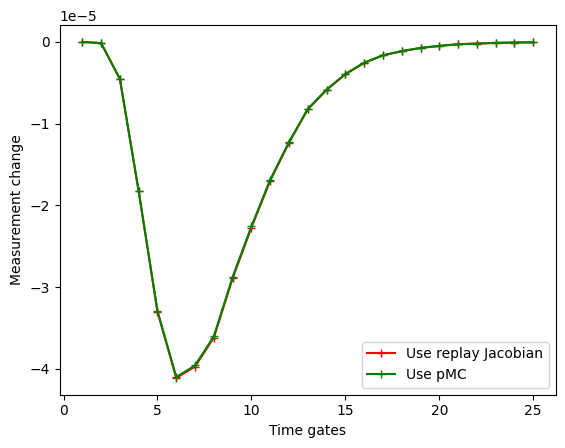

In [25]:
# Plotting results
import matplotlib.pyplot as plt
plt.plot(range(1, jac.shape[3] + 1), dphi, 'r-+', range(1, jac.shape[3] + 1), dphi2, 'g-+')
plt.legend(['Use replay Jacobian', 'Use pMC'])
plt.xlabel('Time gates')
plt.ylabel('Measurement change')
plt.show()